# Hatchspace area - relief map

Generating relief maps in the neighborhood of a given (lat, lon) point.

Based on code from 2017/neighborhood.ipynb which used 1 arcsec usgs data.

This still runs too slowly - I'm doing too many things outside numpy 
and using the full data set too much - but at least it's working. :)

Jim Mahoney | May 2019

In [1]:
import subprocess
hostname = subprocess.check_output("hostname").decode('utf-8')[:-1]
print('host: ', hostname)

import sys
print('python:')
print(sys.version)


host:  softmaple
python:
3.6.8 |Anaconda custom (64-bit)| (default, Dec 29 2018, 19:04:46) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [2]:
# my standard imports for numerical work
from matplotlib.pyplot import plot
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# and libraries for elevation .img, 3D, and .stl files
import gdal
import stl_tools
import scipy.ndimage
from stl import mesh    # part of numpy-stl
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image
from matplotlib.mlab import griddata

# ane other imports
import time

In [3]:
#  *** change these values ***

#neighborhood = {'lat0' : 42.840521,    # | 
#                'lon0' : -72.734916,   # |   Marlboro College
#                'size' : 2000.0        # |   2km  (x & y length)
#             }


neighborhood = {'lat0' :  42.850000,   # | 
                'lon0' : -72.561972,   # |   HatchSpace 42°51'00.1"N 72°33'43.1"W from maps.google.com
                'size' : 4000.0        # |   4km  (x & y length)  (hatchspace to top of wantastiquit is 2km)
             }

# map center: 80m elevation ; mt wantastiquit elevation : 423m
# www.google.com/maps/search/?api=1&query=42.850000,-72.561972

output_stl_file = 'hatchspace_4km_355m.stl'   # renamed after setting sizes

nu = 512                             # number of points in each direction in the uniform grid


In [5]:
# data source 
# USGS NED 43N 73W (at top left) 1/3 arcsec latitude & longitude resolution, 1m elevation resolution
# April 2019 : https://www.sciencebase.gov/catalog/item/581d2181e4b08da350d53334
filename = '../USGS_NED_13_n43w073_IMG/USGS_NED_13_n43w073_IMG.img'
data_usgs = gdal.Open(filename).ReadAsArray()  
print("data ({}) is {} x {} pixels with values (elevation in meters) {:.2f} to {:.2f}".format(
    type(data_usgs), len(data_usgs[0]), len(data_usgs), data_usgs.min(), data_usgs.max()))

# Map data values are elevation in meters.

# Bounding coordinates from USGS_NED_13_n43w073_IMG_meta.txt downloaded April 16 2019.
west  = -73.0005555549942
east  = -71.9994444446048
north = 43.0005555548959
south = 41.9994444445064

# number data points in each direction
N_usgs = data_usgs.shape[0]

# The map data is a numpy array, data[row][col] i.e. (y,x) i.e. (lat,lon) with 0,0 at the top left.
# So (I think) the conversions from i (index) to (lon,lat) (in x,y directions) is
i2lon = lambda column: west + column * (east - west) / (N_usgs - 1)
i2lat = lambda row: north + row * (south - north) / (N_usgs - 1)

print("USGS longitude edges, left & right : ", i2lon(0), i2lon(N_usgs - 1))
print("USGS lattitude edges, top & bottom : ", i2lat(0), i2lat(N_usgs - 1))

data (<class 'numpy.ndarray'>) is 10812 x 10812 pixels with values (elevation in meters) 10.98 to 1096.80
USGS longitude edges, left & right :  -73.0005555549942 -71.9994444446048
USGS lattitude edges, top & bottom :  43.0005555548959 41.9994444445064


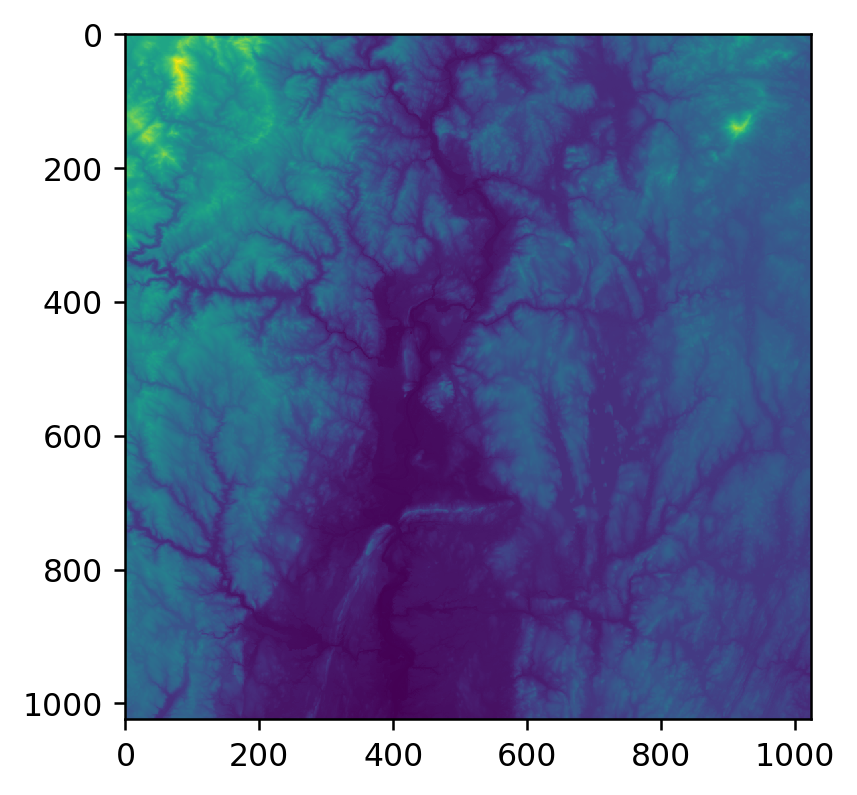

In [6]:
# To see an image of that usgs 1 degree square data, make this True and evaluate.
if True:
    # Smooth & resize
    output_size = 1024                         # new y size in pixels
    scaling = float(output_size) / len(data_usgs)   # (new_size/old_size)
    smoothing_width = int(1.0 / scaling)
    scipy.ndimage.gaussian_filter(data_usgs, sigma=smoothing_width)
    data1024 = scipy.ndimage.zoom(data_usgs, scaling)
    # And take a look.
    # (Note that (x,y) in this image are (lat,long), which is *not* distance on the ground.)
    # (And note that 227 is dots-per-inch for a 27" 5120 x 2880 display,
    # with figsize width,height in inches ... or something.)
    figure = plt.figure(dpi=227, figsize=(4, 4))
    image = plt.imshow(data1024)
    plt.show(image)

In [7]:
# Coord conversions : lon,lat <=> x,y position (in meters, relative to neighborhood)

# (I'm choosing to look at rectangular regions as defined by distances on the ground.
# This is close to but not quite the same as a rectangles defined by (lat,lon) coords,
# since (lat,lon) rectangles are physically wider on the side closest to the equator.)

r_earth = 6731000.0                         # meters
deg2meters = 2 * np.pi * r_earth / 360.0    # degrees to meters
deg2rad = 2 * np.pi / 360.0                  # degrees to radians

def lonlat2xy(lon, lat):
    """ convert lat,lon to x,y ground coords """
    y = (lat - neighborhood['lat0']) * deg2meters
    x = (lon - neighborhood['lon0']) * deg2meters * np.cos(np.deg2rad(lat))
    return (x, y)

def xy2lonlat(x, y):
    lat = neighborhood['lat0'] + y/deg2meters
    lon = neighborhood['lon0'] + x/deg2meters/np.cos(np.deg2rad(lat))
    return (lon, lat)

def in_neighborhood(lon, lat):
    # Do the position check using physical distances, not just (lat,lon).
    (x, y) = lonlat2xy(lon, lat)
    half = neighborhood['size']/2.0
    return (-half <= x <= half) and (-half <= y <= half)

def from_neighborhood(lon, lat):
    """ Distance from neighborhood center """
    (x, y) = latlon2xy(lon, lat)
    return np.sqrt(x*x + y*y)

def point2xyz(p):
    """ convert (lon, lat, z) triple to (x,y,z)"""
    (x,y) = lonlat2xy(p[0], p[1])
    return (x, y, p[2])


In [13]:
# neighborhood corners
d = neighborhood['size']/2
[xy2lonlat(x,y) for x in (-d,d) for y in (-d,d)]

[(-72.58518698628924, 42.83297555206862),
 (-72.58519978730673, 42.867024447931385),
 (-72.53875701371075, 42.83297555206862),
 (-72.53874421269326, 42.867024447931385)]

In [123]:
# usgs lattitude & longitude arrays
lat_usgs = list(map(i2lat, range(N_usgs)))
lon_usgs = list(map(i2lon, range(N_usgs)))

In [137]:
# usgs lat & lon meshgrids
(longridusgs, latgridusgs) = np.meshgrid(lon_usgs, lat_usgs)

In [138]:
longridusgs[0:3,0:3] # increases to the right

array([[-73.00055555, -73.00046295, -73.00037035],
       [-73.00055555, -73.00046295, -73.00037035],
       [-73.00055555, -73.00046295, -73.00037035]])

In [139]:
latgridusgs[0:3,0:3] # increases up

array([[ 43.00055555,  43.00055555,  43.00055555],
       [ 43.00046295,  43.00046295,  43.00046295],
       [ 43.00037035,  43.00037035,  43.00037035]])

In [129]:
#
# TODO : create a smaller subset of the usgs data near the neighborhood
# (tried with the *_may23 file, but something went wrong)
#

In [140]:
# A big list of all the (lat,lon,Z) usgs data points - slow!   
# (maybe make with zip? or take a subset of points near neighborhood before these steps)
points_usgs = [(longridusgs[i,j], latgridusgs[i,j], data_usgs[i,j]) \
               for i in range(N_usgs) for j in range(N_usgs)]
len(points_usgs)

116899344

In [141]:
# Filter the usgs points to find those within the neighborhood.
points = list(filter(lambda p: in_neighborhood(p[0], p[1]), points_usgs))
print("number of points in neighborhood is {}".format(len(points)))
nsize = int(np.sqrt(len(points)))
print("which is about {} x {}".format(nsize, nsize))

number of points in neighborhood is 184136
which is about 429 x 429


In [142]:
# Convert (lon,lat,z) to (x,y,z)
xyz_points = list(map(point2xyz, points))

In [143]:
xyz_points[:10]

[(-1995.4374651359706, 1989.1493853834495, 157.64281),
 (-1987.4641446879073, 1989.1493853834495, 157.05565),
 (-1979.4908242398435, 1989.1493853834495, 157.61867),
 (-1971.5175037930037, 1989.1493853834495, 156.45619),
 (-1963.5441833449404, 1989.1493853834495, 154.75723),
 (-1955.5708628968766, 1989.1493853834495, 154.12828),
 (-1947.5975424488133, 1989.1493853834495, 155.44995),
 (-1939.62422200075, 1989.1493853834495, 156.53741),
 (-1931.6509015526867, 1989.1493853834495, 156.54279),
 (-1923.677581104623, 1989.1493853834495, 154.72403)]

In [144]:
# Make a uniform grid for the neighborhood
dx =  neighborhood['size']/ nu  # grid spacing in meters
xu = (np.array(range(nu)) - nu/2) * dx
yu = (nu/2 - np.array(range(nu))) * dx   # backwards order, to get z_grid stored top to bottom

In [145]:
# interpolate the data onto the uniform grid.

# a tricky way to go from [(x1,y1,z1), (x2,y2,z2),...] to [(x1,x2,..), (y1,y2,..), (z1,z2..)]
(x, y, z) = list(zip(*xyz_points))   

# Interpolate the data onto the uniform grid
zu_grid_masked = griddata(x,y,z, xu,yu, interp='linear')

# make 2d meshes for the x,y coords
xu_grid, yu_grid = np.meshgrid(xu, yu)

In [146]:
# adjust height scale and fill in missing values

# range of heights
(zmin, zmax) = (np.min(zu_grid_masked), np.max(zu_grid_masked))

wood_size = 12   # size in inches of final product ... irrelevant since I'll rescale it later.
height_inches = wood_size * (zmax - zmin) / neighborhood['size']
print('If wood width is {}" then vertical height at 1:1 scale is {:4.2f}."'.format(wood_size, height_inches ))

# meshgrid returns a "masked" object with missing values.
# This replaces them with the lowest.
zu_grid = zu_grid_masked.filled(zmin)

If wood width is 12" then vertical height at 1:1 scale is 1.06."


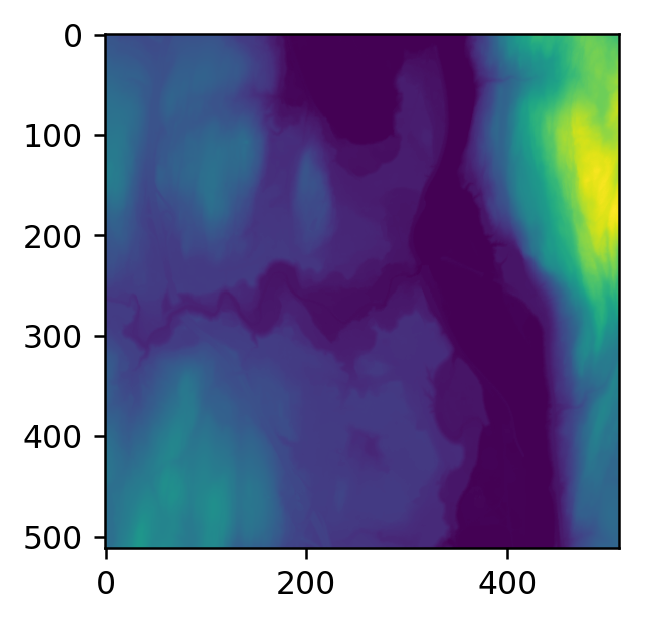

In [179]:
# Here's what we have before smoothing.
figure = plt.figure(dpi=227, figsize=(3,3))
image = plt.imshow(zu_grid)
plt.show(image)

In [148]:
# Apply Gaussian smoothing

smoothing_distance = (0.25*nu)/nsize # pixels ; size of this grid / approx spacing of data
print("using {} pixel smoothing ".format(smoothing_distance))
zu_grid = scipy.ndimage.gaussian_filter(zu_grid, sigma=smoothing_distance)

#optionally - adjust image size here
#data512 = scipy.ndimage.zoom(data, scaling)

using 0.29836829836829837 pixel smoothing 


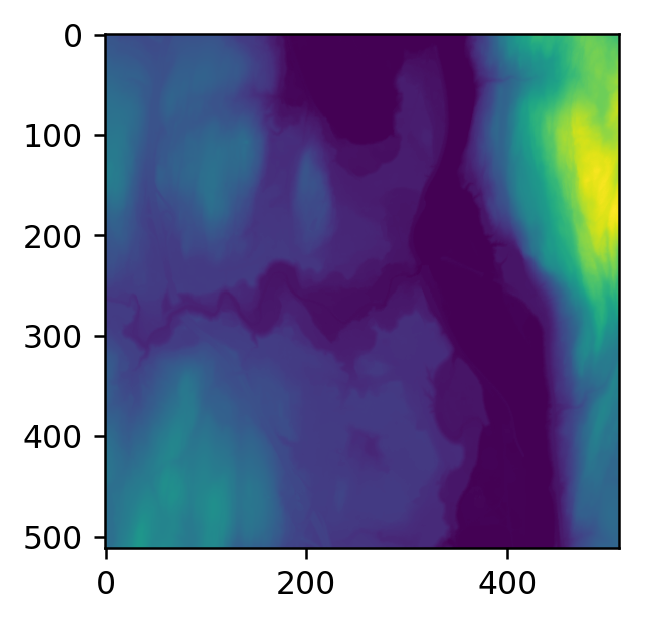

In [178]:
# ... and look at what we have again.
figure2 = plt.figure(dpi=227, figsize=(3,3))
image2 = plt.imshow(zu_grid)
plt.show(image2)

In [164]:
# create the stl file
verticalscaling = (height_inches/(zmax-zmin))/(wood_size/nu)
stl_tools.numpy2stl(zu_grid, output_stl_file, solid=False, ascii=False,
                    scale=verticalscaling, max_width=wood_size, max_depth=wood_size)

In [171]:
print("elevation max-min = ", zmax-zmin, " in meters ")

elevation max-min =  354.6305952  in meters 


In [174]:
# height / size
vertical_to_horizontal = (zmax - zmin)/neighborhood['size']
print("ratio of height to horizontal size is ", vertical_to_horizontal)

ratio of height to horizontal size is  0.0886576488001


In [175]:
print("Therefore with a horizontal size of ", wood_size , " the vertical size should be ", wood_size * vertical_to_horizontal)

Therefore with a horizontal size of  12  the vertical size should be  1.0638917856



I can check the stl dimensions in blender;
see https://blender.stackexchange.com/questions/32283/what-are-all-values-in-bound-box .

In the blendere python console, after importing it :

    > h = bpy.data.objects['Hatchspace']
    > p = [v[:] for v in h.bound_box]
    > for i in p: 
    ...  print(i)

which gives

    (-6.011741638183594, -6.011741638183594, 0.0)
    (-6.011741638183594, -6.011741638183594, 1.0659310817718506)
    (-6.011741638183594, 5.988258361816406, 1.0659310817718506)
    (-6.011741638183594, 5.988258361816406, 0.0)
    (5.988258361816406, -6.011741638183594, 0.0)

... which looks fine.
